<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [58]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, bernoulli, beta

import pylab as plt
from scipy.stats import ttest_ind

In [13]:
# datos
df=pd.read_csv('../6.4_lab-AB-Testing/data/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [16]:
# transformacion
cross=pd.crosstab(df.retention_1, df.version)
cross

version,gate_30,gate_40
retention_1,,
False,24666,25370
True,20034,20119


In [19]:
cross2=pd.crosstab(df.retention_7, df.version)
cross2

version,gate_30,gate_40
retention_7,,
False,36198,37210
True,8502,8279


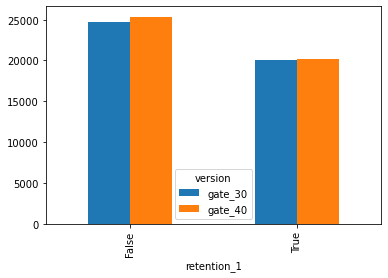

In [5]:
pd.crosstab(df.retention_1, df.version).plot(kind='bar');

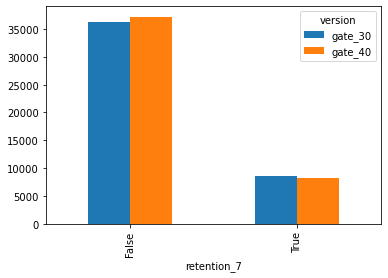

In [20]:
pd.crosstab(df.retention_7, df.version).plot(kind='bar');

In [21]:
df.shape

(90189, 5)

In [7]:
sesiones=df.userid.value_counts(ascending=False)

sesiones[sesiones>1].count()

0

In [8]:
#no hay que hacer muestreo

In [40]:
ttest_ind(cross['gate_30'], cross['gate_40'])

Ttest_indResult(statistic=-0.11268160703773782, pvalue=0.9205737941653265)

In [41]:
ttest_ind(cross2['gate_30'], cross['gate_40'])

Ttest_indResult(statistic=-0.02798925924793173, pvalue=0.9802124799850114)

In [42]:
# conclusiones: no hay diferencia significativa
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

In [51]:
#otra forma de hacerlo con la z en vez de con la t:

In [52]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [54]:
control = df[df.version=='gate_30'].sample(n=44700, random_state=42) 
tratamiento = df[df.version=='gate_40'].sample(n=44700, random_state=42)
ab_test = pd.concat([control, tratamiento], axis=0) 
ab_test.reset_index(drop=True, inplace=True)
ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False


# Bayes

In [55]:
imps_ctrl, convs_ctrl = 44700, 20034 #es la suma de los true 
imps_test, convs_test = 45489, 20119 

CR_ctrl = convs_ctrl/imps_ctrl 
CR_test = convs_test/imps_test 

f'TASAS: Control={CR_ctrl}, Test={CR_test}' 

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [59]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [60]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [63]:
x=np.linspace(0.43, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

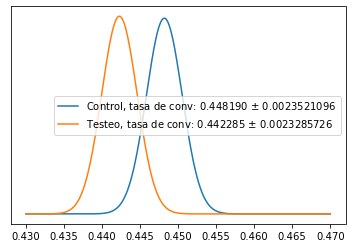

In [64]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [77]:
from bayes import *
prob=calc_prob(beta_test, beta_control)

In [78]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean() 

salto

-0.013175098158249857

In [79]:
%pip install mpmath

from mpmath import betainc

Note: you may need to restart the kernel to use updated packages.


In [80]:
prob=float(prob)

prob

0.037206025180329845

In [82]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.\
format(salto*100, (1-prob)*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 96.28%'